In [13]:
#-------- Import Libraries --------#
import torch
import os
import sys
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sn
import matplotlib.pyplot as plt
from datetime import date
from sklearn.metrics import matthews_corrcoef
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

In [2]:
#-------- Requirements --------#
#Make sure that you have these ready

#!pip install fair-esm

In [3]:
#-------- Import Modules --------#
import encoding as enc
from model import Net, Net_th
import functions as func

In [4]:
#-------- Set Device --------#

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
else:
    print('No GPUs available. Using CPU instead.')
    device = torch.device('cpu')

No GPUs available. Using CPU instead.


In [5]:
#-------- Seeds --------#

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

torch.use_deterministic_algorithms(True)

In [6]:
#-------- Directories --------#

DATADIR = '/data/'
TRAINDIR = '../data/train'
VALIDATIONDIR = '../data/validation'
MATRICES = '/data/Matrices'

In [7]:
#-------- Unzip Train --------#

if len(os.listdir(TRAINDIR)) != 0:
        print("{} already unzipped.".format(TRAINDIR))
else:
    !unzip ../data/train.zip -d ../data/train

    
#-------- Unzip Validation --------#


if len(os.listdir(VALIDATIONDIR)) != 0:
        print("{} already unzipped.".format(VALIDATIONDIR))
else:
    !unzip ../data/validation.zip -d ../data/validation

../data/train already exist.
../data/validation already exist.


In [8]:
print('Train directory:\n\n', '\n'.join(str(p) for p in os.listdir(TRAINDIR)), '\n\n')
print('Validation directory:\n\n','\n'.join(str(p) for p in os.listdir(VALIDATIONDIR)))

Train directory:

 P2_labels.npz
P3_input.npz
P4_input.npz
P2_input.npz
__MACOSX
P1_input.npz
P3_labels.npz
P4_labels.npz
P1_labels.npz 


Validation directory:

 P4_input.npz
__MACOSX
P4_labels.npz


In [ ]:
#-------- Import Dataset --------#

data_list = []
target_list = []

import glob
for fp in glob.glob("../data/train/*input.npz"):
    data = np.load(fp)["arr_0"]
    targets = np.load(fp.replace("input", "labels"))["arr_0"]
    data_list.append(data)
    target_list.append(targets)
    
print(len(data_list))
print(len(target_list))

X_train = np.concatenate(data_list[ :-1])
y_train = np.concatenate(target_list[:-1])
nsamples, nx, ny = X_train.shape
print("Training set shape:", nsamples,nx,ny)

X_val = np.concatenate(data_list[-1: ])
y_val = np.concatenate(target_list[-1: ])
nsamples, nx, ny = X_val.shape
print("Val set shape:", nsamples,nx,ny)

p_neg = len(y_train[y_train == 1])/len(y_train)*100
print("Percent positive samples in train:", p_neg)

p_pos = len(y_val[y_val == 1])/len(y_val)*100
print("Percent positive samples in val:", p_pos)

# make the data set into one dataset that can go into dataloader
train_ds = []
for i in range(len(X_train)):
    train_ds.append([np.transpose(X_train[i]), y_train[i]])

val_ds = []
for i in range(len(X_val)):
    val_ds.append([np.transpose(X_val[i]), y_val[i]])

bat_size = 64
print("\nNOTE:\nSetting batch-size to", bat_size)
train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=bat_size, shuffle=True)
val_ldr = torch.utils.data.DataLoader(val_ds,batch_size=bat_size, shuffle=True)

In [9]:
#-------- Select the netwrok you would like to use, thesis or hecaton code -------#

HACKATON = False # ONLY CNN
THESIS = True # CNN + RNN

In [11]:
###############################
###    Hackaton Code          ###
###############################

if HACKATON:
    
    #-------- Define network --------#

    print("Initializing network")

    # Hyperparameters
    input_size = 420
    num_classes = 1
    learning_rate = 0.01
    epochs = 10

    # Initialize network
    net = Net(num_classes=num_classes).to(device)

    # Loss and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)


    #-------- Train network --------#

    print("Training")

    train_acc, train_loss = [], []
    valid_acc, valid_loss = [], []
    losses = []
    val_losses = []

    for epoch in range(epochs):
        cur_loss = 0
        val_loss = 0

        net.train()
        train_preds, train_targs = [], [] 
        for batch_idx, (data, target) in enumerate(train_ldr):
            X_batch =  data.float().detach().requires_grad_(True)
            target_batch = torch.tensor(np.array(target), dtype = torch.float).unsqueeze(1)

            optimizer.zero_grad()
            output = net(X_batch)

            batch_loss = criterion(output, target_batch)
            batch_loss.backward()
            optimizer.step()

            preds = np.round(output.detach().cpu())
            train_targs += list(np.array(target_batch.cpu()))
            train_preds += list(preds.data.numpy().flatten())
            cur_loss += batch_loss.detach()

        losses.append(cur_loss / len(train_ldr.dataset))
        net.eval()

        ### Evaluate validation
        val_preds, val_targs = [], []
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_ldr): ###
                x_batch_val = data.float().detach()
                y_batch_val = target.float().detach().unsqueeze(1)

                output = net(x_batch_val)

                val_batch_loss = criterion(output, y_batch_val)

                preds = np.round(output.detach())
                val_preds += list(preds.data.numpy().flatten()) 
                val_targs += list(np.array(y_batch_val))
                val_loss += val_batch_loss.detach()

            val_losses.append(val_loss / len(val_ldr.dataset))
            print("\nEpoch:", epoch+1)

            train_acc_cur = accuracy_score(train_targs, train_preds)  
            valid_acc_cur = accuracy_score(val_targs, val_preds) 

            train_acc.append(train_acc_cur)
            valid_acc.append(valid_acc_cur)

    
            print("Training loss:", round(losses[-1].item(),3), "Validation loss:", round(val_losses[-1].item(),3), end = "\n")
            print("MCC Train:", round(matthews_corrcoef(train_targs, train_preds),3), "MCC val:", round(matthews_corrcoef(val_targs, val_preds),3) )

    print('\nFinished Training ...')


    #-------- Save results --------#

    results = pd.DataFrame(list(zip( (x[0] for x in val_targs), val_preds)),columns =['target', 'pred'])
    print(results)

    #results.to_csv('results/df_targets_preds.csv'.format(str(date.today())), index=False)


    #-------- Performance Evaluation --------#
    # The results change every time we train, we should check why (maybe we missed something or did wrong with the seeds?)

    print("AUC: ", roc_auc_score(results['target'], results['pred']))
    print("MCC: ", matthews_corrcoef(results['target'], results['pred']))

    confusion_matrix = pd.crosstab(results['target'], results['pred'], rownames=['Actual'], colnames=['Predicted'])
    sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
    plt.show()



Training set shape: 4180 420 54
Validation set shape: 1526 420 54
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Early stopping



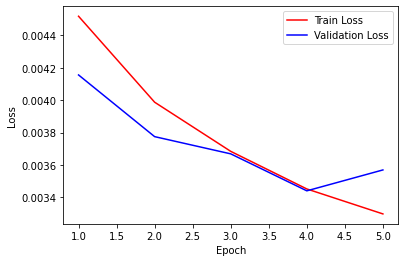

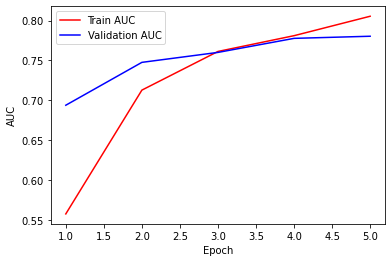

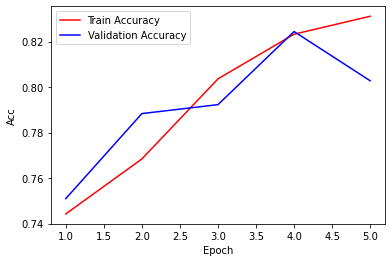

      target  pred
0          0     0
1          1     1
2          0     0
3          1     1
4          0     0
...      ...   ...
1521       0     0
1522       1     0
1523       0     0
1524       0     0
1525       1     0

[1526 rows x 2 columns]
AUC:  0.7094860843207494
MCC:  0.4455744762591951


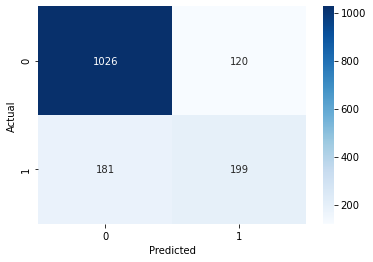

301


In [15]:

###############################
###    Thesis Code          ###
###############################

if THESIS:
    
    #-------- Initials --------#

    # All features
    features = list(range(54))
    # Only one-hot
    #features = list(range(0,20))
    # Only energy terms
    #features = list(range(20,54))
    # One-hot and global energy terms
    #features = list(range(20)) + list(range(27,54))
    # One-hot and per-residue energy terms
    #features = list(range(27))
    # Only per-residue energy terms
    #features = list(range(20,27))
    # One-hot and total scores
    #features = list(range(20)) + [27, 41, 48]
    # Only global energy terms
    #features = list(range(27,54))

    # Define network
    # Whole sequence
    residues = list(range(416))
    # Without MHC
    #residues = list(range(179,416))
    # Without peptide
    #residues = list(range(179)) + list(range(188,416))
    # Without TCR
    #residues = list(range(188))

    # Hyperparameters
    input_size = len(residues)
    num_classes = 1
    learning_rate = 0.001
    bat_size = 128
    epochs = 100
    n_features = len(features)
    criterion = nn.BCEWithLogitsLoss()


    #-------- Train --------#
    X_train = np.concatenate(data_list[ :-1])
    y_train = np.concatenate(target_list[:-1])
    nsamples, nx, ny = X_train.shape
    print("Training set shape:", nsamples,nx,ny)

    X_valid = np.concatenate(data_list[-1: ])
    y_valid = np.concatenate(target_list[-1: ])
    nsamples, nx, ny = X_valid.shape
    print("Validation set shape:", nsamples,nx,ny)

    # Dataloader
    train_ds = []
    for i in range(len(X_train)):
        train_ds.append([np.transpose(X_train[i][:,features]), y_train[i]])
    val_ds = []
    for i in range(len(X_valid)):
        val_ds.append([np.transpose(X_valid[i][:,features]), y_valid[i]])
    train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=bat_size, shuffle=True)
    val_ldr = torch.utils.data.DataLoader(val_ds,batch_size=bat_size, shuffle=True)

    # Initialize network
    net = Net_th(num_classes=num_classes, n_features=n_features).to(device)

    # Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate,
                           weight_decay=0.0005,
                           amsgrad=True,
                           )

    train_acc, train_losses, train_auc, valid_acc, valid_losses, valid_auc, val_preds, val_targs = func.train_th(net, optimizer, train_ldr, val_ldr, [], [], epochs, criterion)


    #-------- Performance --------#
    epoch = np.arange(1,len(train_losses)+1)
    plt.figure()
    plt.plot(epoch, train_losses, 'r', epoch, valid_losses, 'b')
    plt.legend(['Train Loss','Validation Loss'])
    plt.xlabel('Epoch'), plt.ylabel('Loss')

    epoch = np.arange(1,len(train_auc)+1)
    plt.figure()
    plt.plot(epoch, train_auc, 'r', epoch, valid_auc, 'b')
    plt.legend(['Train AUC','Validation AUC'])
    plt.xlabel('Epoch'), plt.ylabel('AUC')

    epoch = np.arange(1,len(train_acc)+1)
    plt.figure()
    plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
    plt.legend(['Train Accuracy','Validation Accuracy'])
    plt.xlabel('Epoch'), plt.ylabel('Acc')
    plt.show()

    
    #-------- Save results --------#

    results = pd.DataFrame(list(zip( (int(x) for x in val_targs), (int(x) for x in val_preds))),columns =['target', 'pred'])
    print(results)

    #results.to_csv('results/df_targets_preds_th.csv'.format(str(date.today())), index=False



    #-------- Performance Evaluation --------#
    # The results change every time we train, we should check why (maybe we missed something or did wrong with the seeds?)

    print("AUC: ", roc_auc_score(results['target'], results['pred']))
    print("MCC: ", matthews_corrcoef(results['target'], results['pred']))

    confusion_matrix = pd.crosstab(results['target'], results['pred'], rownames=['Actual'], colnames=['Predicted'])
    sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
    plt.show()

    print( len([i for i, (a, b) in enumerate(zip(results['pred'], results['target'])) if a != b]))

In [ ]:
ID = 'give_an_ID_to_this_notebook'
nb = 'main'

os.system('jupyter nbconvert {} --output {} --to html'.format(nb + '.ipynb', nb + '-' + ID +  '-' + str(date.today()) + '.html'))